In [1]:
import pandas as pd
import numpy as np
import math
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('df5_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [16]:
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col+'_random'] = [random.randint(0,0) for r in range(len(df))]

In [17]:
cols = ['gw_time'] + ['temperature_329']+['humidity_329']+ ['temperature_329_prime'] + ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id] +['operation_'+str(_id)+'_random' for _id in freezer_id]
df = df[cols]

In [18]:
df = df.dropna()

In [19]:
TEST_SIZE = 8000
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]
train.shape, test.shape

((72120, 11), (8000, 11))

In [20]:
from sklearn.preprocessing import StandardScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
for col in cols[1:-3]:
    train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_13744\2926434095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_13744\2926434095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_13744\2926434095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a 

In [21]:
feature_cols1 = ['operation_'+str(_id) for _id in freezer_id] + ['temperature_329_prime']# + ['humidity_329']
feature_cols2 = ['operation_'+str(_id)+'_random' for _id in freezer_id] + ['temperature_329_prime']#+ ['humidity_329']
label_cols =  ['temperature_329']

In [23]:
train_feature = train[feature_cols1]
train_label = train[label_cols]

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = True)

x_train.shape, x_valid.shape
# ((57676, 20, 21), (14419, 20, 21))

((57696, 4), (14424, 4))

In [24]:
test_feature = test[feature_cols1]
test_feature2 = test[feature_cols2]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature.shape, test_label.shape

((8000, 4), (8000, 1))

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
# model.add(Dense(32,activation = 'ReLU'))
# model.add(Dense(64,activation = 'ReLU'))
model.add(Dense(32,activation='ReLU'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = './tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint],
                    verbose = 1,
                    shuffle = True)

Epoch 1/200
897/902 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 1: val_loss improved from inf to 0.00001, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 5s 4ms/step - loss: 0.0018 - val_loss: 9.7400e-06
Epoch 2/200
890/902 [============================>.] - ETA: 0s - loss: 7.8508e-06
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 4s 4ms/step - loss: 7.8354e-06 - val_loss: 7.1753e-06
Epoch 3/200
899/902 [============================>.] - ETA: 0s - loss: 7.0782e-06
Epoch 3: val_loss improved from 0.00001 to 0.00001, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 4s 5ms/step - loss: 7.0771e-06 - val_loss: 6.9688e-06
Epoch 4/200
893/902 [============================>.] - ETA: 0s - loss: 7.5654e-06
Epoch 4: val_loss did not improve from 0.00001
902/902 [==============================] - 4s 4ms/step - loss: 7.5646e-06 - val_lo

In [11]:
model.save('my_custom_model')

INFO:tensorflow:Assets written to: my_custom_model\assets


INFO:tensorflow:Assets written to: my_custom_model\assets


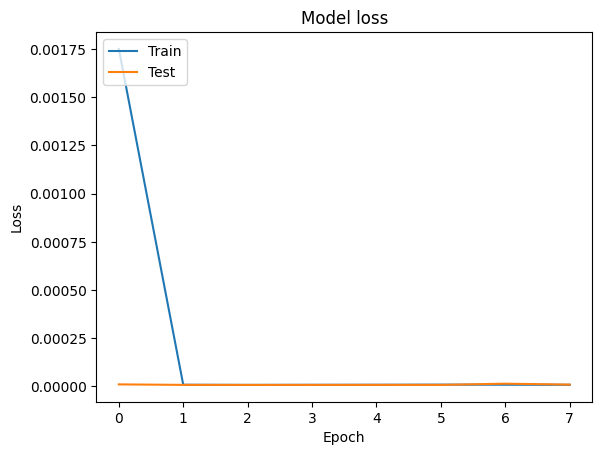

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)
pred2 = model.predict(test_feature2)

250/250 [==============================] - 1s 3ms/step


MSE:  0.0030022271001194966
MAE:  0.031917809798524245


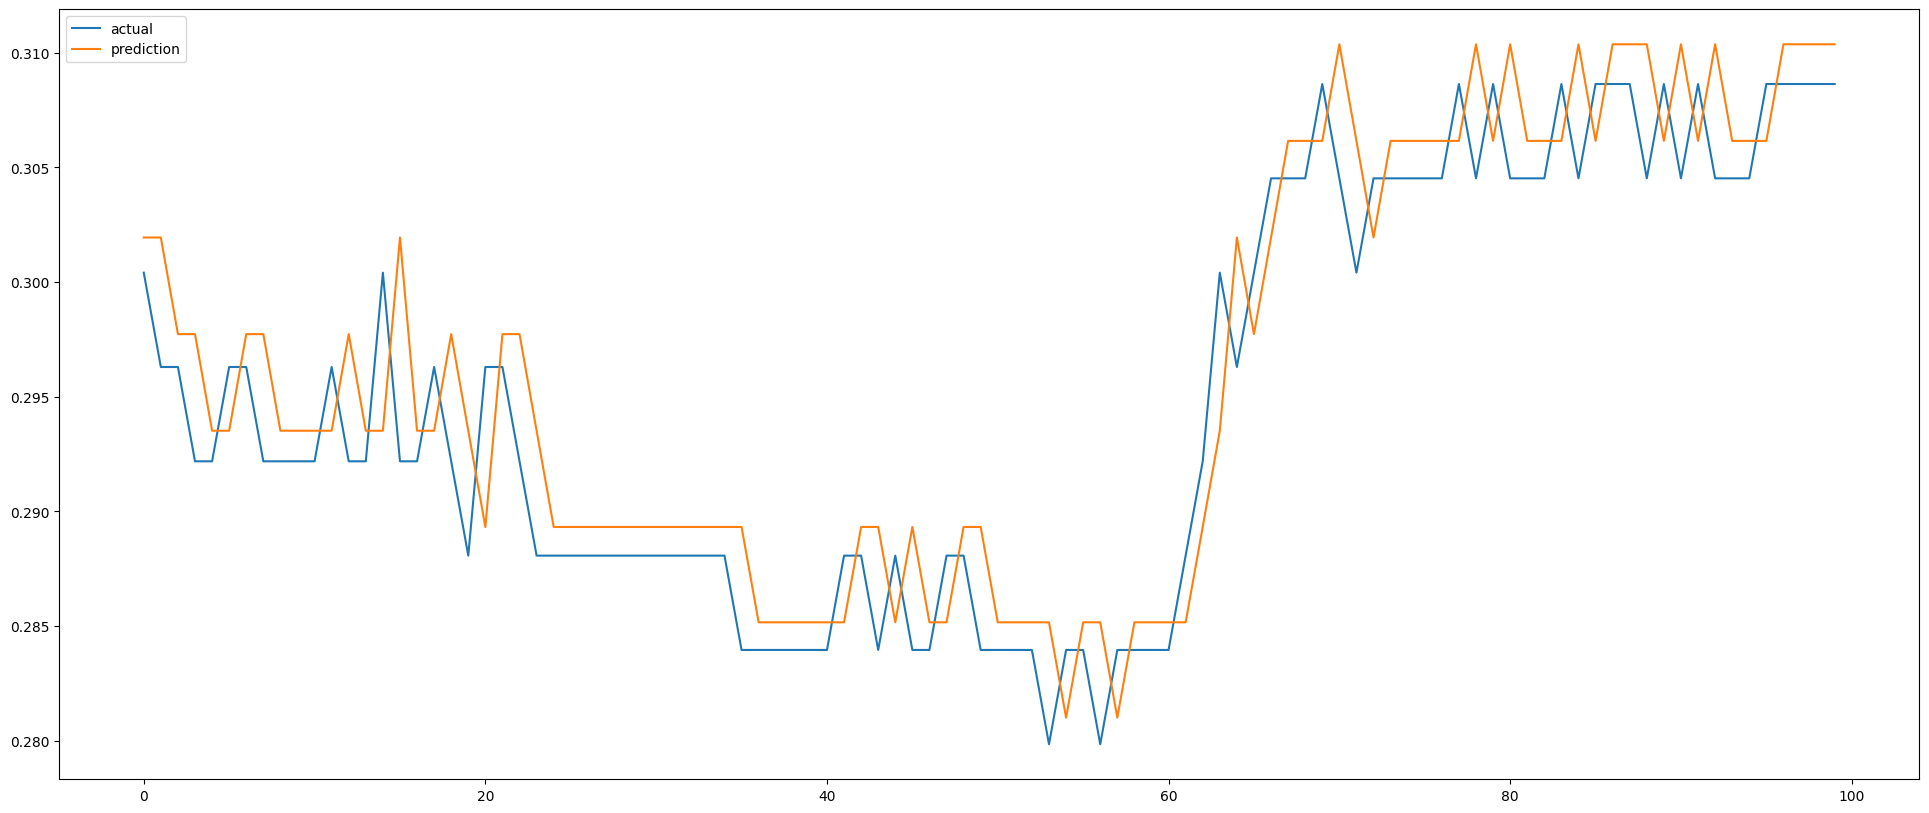

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred))
print("MAE: ", mean_absolute_error(test_label.values, pred))
plt.figure(figsize=(24,10))
plt.plot(test_label.values[:100], label='actual')
plt.plot(pred2[:100], label='prediction')
plt.legend()
plt.show()

In [120]:
test_label.values[:20]

array([[0.30041152],
       [0.2962963 ],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.30041152],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.29218107],
       [0.28806584]])

In [121]:
pred[:20]

array([[0.29850602],
       [0.29852733],
       [0.29455122],
       [0.29456452],
       [0.29062834],
       [0.29068956],
       [0.2947269 ],
       [0.29476416],
       [0.29080668],
       [0.29084134],
       [0.2908892 ],
       [0.29093447],
       [0.2949532 ],
       [0.2909877 ],
       [0.29098505],
       [0.2989373 ],
       [0.2909744 ],
       [0.2910223 ],
       [0.29504633],
       [0.29108623]], dtype=float32)

MSE:  0.010041209866676847
MAE:  0.07921227328851922


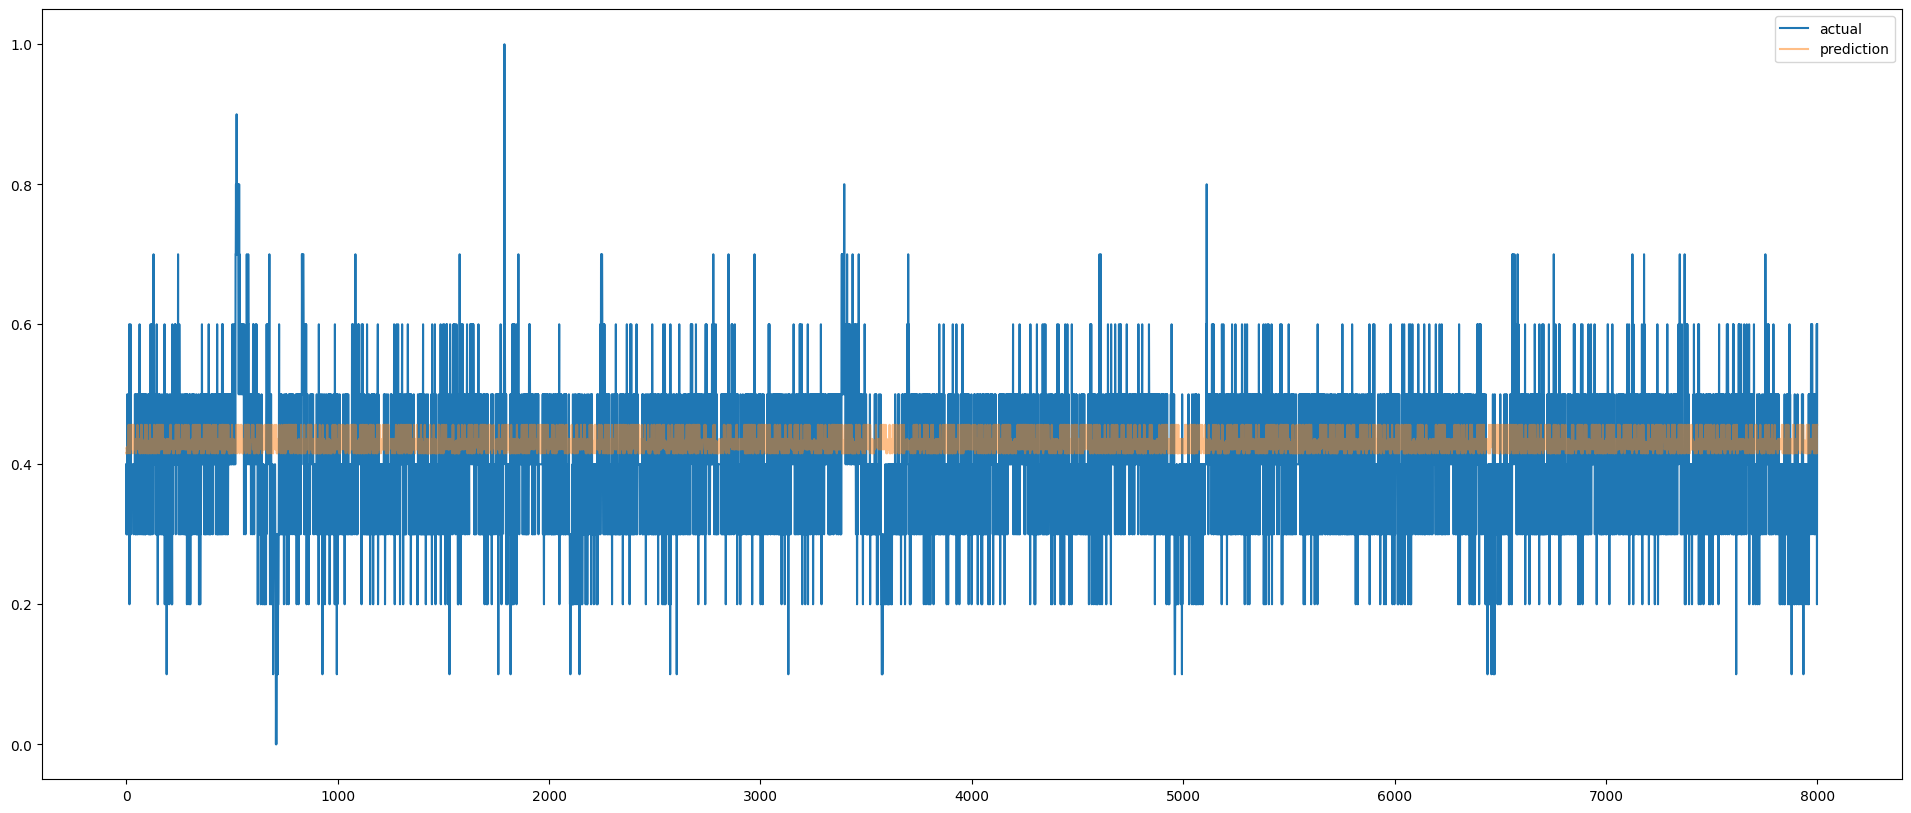

In [148]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred2))
print("MAE: ", mean_absolute_error(test_label.values, pred2))
plt.figure(figsize=(24,10))
plt.plot(test_label.values, label='actual')
plt.plot(pred2, label='prediction', alpha = 0.5)
plt.legend()
plt.show()